In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
from sklearn.preprocessing import StandardScaler
from utils import transform_bbch_data, count_daily_measurements, clean_timestamp, find_common_dates, calculate_cumulative_gdd, calculate_accumulated_nitrates, calculate_cumulative_par, daily_average_humidity, merge_variables, explained_variance_visualizer, pca
# 3D visuals
import plotly.graph_objects as go
import plotly.express as px  # For color palettes
from sklearn.decomposition import PCA


### <b> Dataset Creation </b>

* Goal: Create a dataset based on lettuce plants' biometry and environmental variables for a greenhouse experiment

#### <b> Biometry variables </b>

* <b> Diameter </b>: The diameter of a chosen leaf of the plant, expressed in centimeters (cm)
* <b> Perpendicular </b>: The length of perpendicular line to the chosen diameter of a chosen leaf, expressed in centimeters (cm)
* <b> Weight </b>: The weight of the plant, expressed in kilograms (Kg)
* <b> Height </b>: The height of the plant, expressed in centimeters (cm)
* <b> Thickness </b>: Leaf thickness, expressed in centimeters (cm)
* <b> Number of leaves (N leaves) </b>: The number of leaves the plant presents 

#### <b> Environmental variables </b>

* <b> Irrigation </b>
* <b> Humidity </b>
* <b> Temperature </b>
* <b> PAR radiation </b>


### <b> Biometry </b>

In [2]:
# Previously created biometry dataset
biometry = pd.read_csv("data/final_biometric_data.csv")
biometry.rename(columns={"Unnamed: 0":"Date", "Sample":"Sample?", "CODE":"Sample"}, inplace=True)
biometry.drop(columns=['Max. Temp.', 'Min. Temp.', 'Mean. Temp.',
       'Max. Hum.', 'Min. Hum.', 'Mean. Hum.', 'Combined Temperature Average',
       'Combined Temperature Std Dev', 'Combined Humidity Average',
       'Combined Humidity Std Dev','Sample?','BBCH'], inplace=True)

In [3]:
bbch = pd.read_excel('raw_data/biom_to_BBCH.xlsx')
bbch.drop(columns={'Number', 'Line', 'Sample'}, inplace=True)

In [4]:
bbch_cols = list(bbch.columns)

In [5]:
new_bbch = transform_bbch_data(bbch)

In [6]:
new_bbch.rename(columns={'CODE':'Sample'}, inplace=True)

In [7]:
new_bbch

,Sample,Date,BBCH
0,RNGRA1,2024-09-07,19
1,RNGRA1,2024-09-11,19
2,RNGRA1,2024-09-14,19
3,RNGRA1,2024-09-17,37
4,RNGRA1,2024-09-20,37
...,...,...,...
355,RWGRC5,2024-09-17,19
356,RWGRC5,2024-09-20,19
357,RWGRC5,2024-09-24,19
358,RWGRC5,2024-09-29,19


In [8]:
# Set Date column to datetime type
biometry['Date'] = pd.to_datetime(biometry['Date'])

<b> Total number of plants </b>

In [9]:
biometry['Sample'].nunique()

45

* There's 45 plants in this experiment, each represented by its unique code, represented in the CODE column

<b> Dates where biometry was measured </b>

In [10]:
biometry['Date'].nunique()

8

* Measurements of the biometry of the plants were taken at 8 different days

### <b> Irrigation </b>

In [11]:
irrigation = pd.read_excel("raw_data/irrigation.xlsx")

In [12]:
# Set Date column to datetime type
irrigation['Date'] = pd.to_datetime(irrigation['Date'])

In [13]:
irrigation

,Date,Sample,Quantity (mL)
0,2024-08-24,rngra1,50.0
1,2024-08-24,rngra2,50.0
2,2024-08-24,rngra3,50.0
3,2024-08-24,rngra4,50.0
4,2024-08-24,rngra5,50.0
...,...,...,...
985,2024-10-01,rwgrc1,7.5
986,2024-10-01,rwgrc2,14.5
987,2024-10-01,rwgrc3,5.0
988,2024-10-01,rwgrc4,12.0


<b> Number of irrigation days </b>

In [14]:
irrigation['Date'].nunique()

23

* There's 23 days of irrigation

### <b> Temperature </b>

In [15]:
temperature = pd.read_excel("raw_data/inside_2.xlsx")[['date','temperature']]

In [16]:
temperature.rename(columns={'date':'Date'}, inplace=True)

In [17]:
temperature

,Date,temperature
0,2024-08-22,18.200000
1,2024-08-22,17.200000
2,2024-08-22,17.300000
3,2024-08-22,17.700000
4,2024-08-22,17.400000
...,...,...
941,2024-10-03,20.703388
942,2024-10-03,21.296177
943,2024-10-03,21.758629
944,2024-10-03,21.531219


In [18]:
# Set Date column to datetime type
temperature['Date'] = pd.to_datetime(temperature['Date'])

In [19]:
temperature

,Date,temperature
0,2024-08-22,18.200000
1,2024-08-22,17.200000
2,2024-08-22,17.300000
3,2024-08-22,17.700000
4,2024-08-22,17.400000
...,...,...
941,2024-10-03,20.703388
942,2024-10-03,21.296177
943,2024-10-03,21.758629
944,2024-10-03,21.531219


In [20]:
temperature['Date'].nunique()

43

* Measurements of the temperature of the greenhouse were taken at 43 different days

In [21]:
# Daily number of temperature measurements
temp_date_dict = count_daily_measurements(temperature)

In [22]:
temp_date_dict

{Timestamp('2024-08-22 00:00:00'): 25,
 Timestamp('2024-08-23 00:00:00'): 24,
 Timestamp('2024-08-24 00:00:00'): 24,
 Timestamp('2024-08-25 00:00:00'): 24,
 Timestamp('2024-08-26 00:00:00'): 24,
 Timestamp('2024-08-27 00:00:00'): 24,
 Timestamp('2024-08-28 00:00:00'): 24,
 Timestamp('2024-08-29 00:00:00'): 24,
 Timestamp('2024-08-30 00:00:00'): 24,
 Timestamp('2024-08-31 00:00:00'): 24,
 Timestamp('2024-09-01 00:00:00'): 23,
 Timestamp('2024-09-02 00:00:00'): 24,
 Timestamp('2024-09-03 00:00:00'): 24,
 Timestamp('2024-09-04 00:00:00'): 24,
 Timestamp('2024-09-05 00:00:00'): 24,
 Timestamp('2024-09-06 00:00:00'): 24,
 Timestamp('2024-09-07 00:00:00'): 24,
 Timestamp('2024-09-08 00:00:00'): 24,
 Timestamp('2024-09-09 00:00:00'): 24,
 Timestamp('2024-09-10 00:00:00'): 24,
 Timestamp('2024-09-11 00:00:00'): 24,
 Timestamp('2024-09-12 00:00:00'): 19,
 Timestamp('2024-09-13 00:00:00'): 18,
 Timestamp('2024-09-14 00:00:00'): 24,
 Timestamp('2024-09-15 00:00:00'): 24,
 Timestamp('2024-09-16 00

In [23]:
temp_date_dict.values()

dict_values([25, 24, 24, 24, 24, 24, 24, 24, 24, 24, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 19, 18, 24, 24, 16, 9, 14, 21, 20, 24, 14, 13, 23, 24, 24, 22, 24, 23, 23, 24, 24, 15])

* As we can tell by the values of the date_dict dictionary the number of temperature measurements wasn't constant during the experiment.

### <b> Humidity </b>

In [24]:
humidity = pd.read_excel("raw_data/inside_2.xlsx")[['date','humidity']]
humidity.rename(columns={'date':'Date'}, inplace=True)

In [25]:
# Set Date column to datetime type
humidity['Date'] = pd.to_datetime(humidity['Date'])

In [26]:
humidity['Date'].nunique()

43

In [27]:
humidity

,Date,humidity
0,2024-08-22,66.100000
1,2024-08-22,70.700000
2,2024-08-22,74.000000
3,2024-08-22,76.600000
4,2024-08-22,77.800000
...,...,...
941,2024-10-03,86.559822
942,2024-10-03,85.557480
943,2024-10-03,84.059044
944,2024-10-03,82.733772


In [28]:
hum_date_dict = count_daily_measurements(humidity)

In [29]:
hum_date_dict.values()

dict_values([25, 24, 24, 24, 24, 24, 24, 24, 24, 24, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 19, 18, 24, 24, 16, 9, 14, 21, 20, 24, 14, 13, 23, 24, 24, 22, 24, 23, 23, 24, 24, 15])

* The number of humidity measurements follows the number of temperature measurements (captured by the same sensors)

### <b> PAR </b>

In [30]:
par = pd.read_excel('raw_data/PAR.xlsx')

# Set Date column to datetime type using clean_timestamp from utils.py
par['Date'] = par['Date'].apply(clean_timestamp)

In [31]:
par['Date'].nunique()

19

In [32]:
par_date_dict = count_daily_measurements(par)

In [33]:
par_date_dict

{Timestamp('2024-09-02 00:00:00'): 5,
 Timestamp('2024-09-03 00:00:00'): 24,
 Timestamp('2024-09-04 00:00:00'): 24,
 Timestamp('2024-09-05 00:00:00'): 24,
 Timestamp('2024-09-06 00:00:00'): 24,
 Timestamp('2024-09-07 00:00:00'): 23,
 Timestamp('2024-09-08 00:00:00'): 24,
 Timestamp('2024-09-09 00:00:00'): 24,
 Timestamp('2024-09-10 00:00:00'): 24,
 Timestamp('2024-09-11 00:00:00'): 24,
 Timestamp('2024-09-12 00:00:00'): 24,
 Timestamp('2024-09-13 00:00:00'): 25,
 Timestamp('2024-09-14 00:00:00'): 23,
 Timestamp('2024-09-15 00:00:00'): 24,
 Timestamp('2024-09-16 00:00:00'): 23,
 Timestamp('2024-09-17 00:00:00'): 24,
 Timestamp('2024-09-18 00:00:00'): 24,
 Timestamp('2024-09-19 00:00:00'): 24,
 Timestamp('2024-09-20 00:00:00'): 10}

<b> Common Dates amongst biometric and environmental dataframes </b>

In [34]:
dataframes = {'Biometry':biometry, 'Irrigation':irrigation, 'Humidity':humidity,'Temperature':temperature, 'Par':par}

In [35]:
common_dates = find_common_dates(dataframes, check_num = 1)

Biometry x Irrigation | No. Common Dates: 4

Biometry x Humidity | No. Common Dates: 8

Biometry x Temperature | No. Common Dates: 8

Biometry x Par | No. Common Dates: 5

Irrigation x Humidity | No. Common Dates: 23

Irrigation x Temperature | No. Common Dates: 23

Irrigation x Par | No. Common Dates: 11

Humidity x Temperature | No. Common Dates: 43

Humidity x Par | No. Common Dates: 19

Temperature x Par | No. Common Dates: 19



In [36]:
common_dates

{'Biometry x Irrigation': {Timestamp('2024-09-07 00:00:00'),
  Timestamp('2024-09-11 00:00:00'),
  Timestamp('2024-09-17 00:00:00'),
  Timestamp('2024-09-20 00:00:00')},
 'Biometry x Humidity': {Timestamp('2024-09-07 00:00:00'),
  Timestamp('2024-09-11 00:00:00'),
  Timestamp('2024-09-14 00:00:00'),
  Timestamp('2024-09-17 00:00:00'),
  Timestamp('2024-09-20 00:00:00'),
  Timestamp('2024-09-24 00:00:00'),
  Timestamp('2024-09-29 00:00:00'),
  Timestamp('2024-10-03 00:00:00')},
 'Biometry x Temperature': {Timestamp('2024-09-07 00:00:00'),
  Timestamp('2024-09-11 00:00:00'),
  Timestamp('2024-09-14 00:00:00'),
  Timestamp('2024-09-17 00:00:00'),
  Timestamp('2024-09-20 00:00:00'),
  Timestamp('2024-09-24 00:00:00'),
  Timestamp('2024-09-29 00:00:00'),
  Timestamp('2024-10-03 00:00:00')},
 'Biometry x Par': {Timestamp('2024-09-07 00:00:00'),
  Timestamp('2024-09-11 00:00:00'),
  Timestamp('2024-09-14 00:00:00'),
  Timestamp('2024-09-17 00:00:00'),
  Timestamp('2024-09-20 00:00:00')},
 'Ir

* Since there aren't many common dates amongst the biometry dataframes and environmental variables, we'll make use of the available environmental data to calculate cumulative values where possible to gather valuable information and append it to the corresponding biometry entries in the dataframe.

#### <b> Environmental Variables </b>

In [37]:
cumul_gdd = calculate_cumulative_gdd(temperature_df=temperature)

In [38]:
cumul_gdd

,Date,GDD Cumul.
0,2024-08-22,18.750000
1,2024-08-22,18.750000
2,2024-08-22,18.750000
3,2024-08-22,18.750000
4,2024-08-22,18.750000
...,...,...
941,2024-10-03,809.244245
942,2024-10-03,809.244245
943,2024-10-03,809.244245
944,2024-10-03,809.244245


<b> Accumulated PAR </b>

In [39]:
par_cumul = calculate_cumulative_par(par_df=par)

<b> Accumulated Solution and Nitrate Irrigation </b>

In [40]:
irr_df = calculate_accumulated_nitrates(irrigation_df=irrigation)

In [41]:
irr_df

,Date,Sample,Cumul. Irrigation (mL),Cumul. Nitrates (milimoles)
0,2024-08-24,RNGRA1,50.0,0.3000
1,2024-08-24,RNGRA2,50.0,0.3000
2,2024-08-24,RNGRA3,50.0,0.3000
3,2024-08-24,RNGRA4,50.0,0.3000
4,2024-08-24,RNGRA5,50.0,0.3000
...,...,...,...,...
985,2024-10-01,RWGRC1,1084.0,18.4280
986,2024-10-01,RWGRC2,877.5,14.9175
987,2024-10-01,RWGRC3,1045.5,17.7735
988,2024-10-01,RWGRC4,1058.0,17.9860


<b> Average daily Humidity </b>

In [42]:
hum_avg = daily_average_humidity(humidity_df=humidity)

<b> Combine all dataframes </b>

In [43]:
merged_df = merge_variables(bbch_df=new_bbch, biometry_df=biometry, gdd_df=cumul_gdd, par_df=par_cumul, nitrates_df=irr_df)

In [44]:
par_cumul

,Date,PAR Cumul.
0,2024-09-02,87.0
1,2024-09-03,1860.3
2,2024-09-04,3788.5
3,2024-09-05,5441.0
4,2024-09-06,6577.0
5,2024-09-07,8284.7
6,2024-09-08,10229.2
7,2024-09-09,12051.7
8,2024-09-10,14750.7
9,2024-09-11,16804.0


In [45]:
merged_df[merged_df['Sample'] == 'RNGRA3']

,Date,Number,Line,Sample,No leaves,Diameter,Perpendicular,Height,Average Leaf Thickness,BBCH,GDD Cumul.,PAR Cumul.,Cumul. Irrigation (mL),Cumul. Nitrates (milimoles)
2,2024-09-07,16,3,RNGRA3,9,9.8,9.7,10.70,0.000000,19,317.050000,8284.7,350.00,2.1000
47,2024-09-11,16,3,RNGRA3,12,14.3,12.3,12.80,0.000000,19,391.750000,16804.0,462.25,2.7735
92,2024-09-14,16,3,RNGRA3,12,21.2,13.8,12.50,0.000000,19,457.100000,22970.1,530.50,3.1830
137,2024-09-17,16,3,RNGRA3,14,21.5,16.8,11.30,0.000000,19,529.378430,26761.5,661.50,3.9690
182,2024-09-20,16,3,RNGRA3,14,21.5,20.4,11.90,0.416667,19,589.001102,28775.3,737.50,4.4250
227,2024-09-24,16,3,RNGRA3,14,28.5,25.7,13.55,0.293333,19,660.469683,28775.3,862.50,5.1750
272,2024-09-29,16,3,RNGRA3,13,27.8,28.5,13.05,0.430000,19,743.211838,28775.3,997.50,5.9850
317,2024-10-03,16,3,RNGRA3,16,31.4,30.6,11.45,0.264000,19,809.244245,28775.3,1141.00,6.8460


In [46]:
merged_df.to_csv('03_biometric.csv')

In [47]:
merged_df.columns

Index(['Date', 'Number', 'Line', 'Sample', 'No leaves', 'Diameter',
       'Perpendicular', 'Height', 'Average Leaf Thickness', 'BBCH',
       'GDD Cumul.', 'PAR Cumul.', 'Cumul. Irrigation (mL)',
       'Cumul. Nitrates (milimoles)'],
      dtype='object')

### <b> EDA </b>

array([[<Axes: title={'center': 'Date'}>,
        <Axes: title={'center': 'Number'}>,
        <Axes: title={'center': 'Line'}>,
        <Axes: title={'center': 'No leaves'}>],
       [<Axes: title={'center': 'Diameter'}>,
        <Axes: title={'center': 'Perpendicular'}>,
        <Axes: title={'center': 'Height'}>,
        <Axes: title={'center': 'Average Leaf Thickness'}>],
       [<Axes: title={'center': 'BBCH'}>,
        <Axes: title={'center': 'GDD Cumul.'}>,
        <Axes: title={'center': 'PAR Cumul.'}>,
        <Axes: title={'center': 'Cumul. Irrigation (mL)'}>],
       [<Axes: title={'center': 'Cumul. Nitrates (milimoles)'}>,
        <Axes: >, <Axes: >, <Axes: >]], dtype=object)

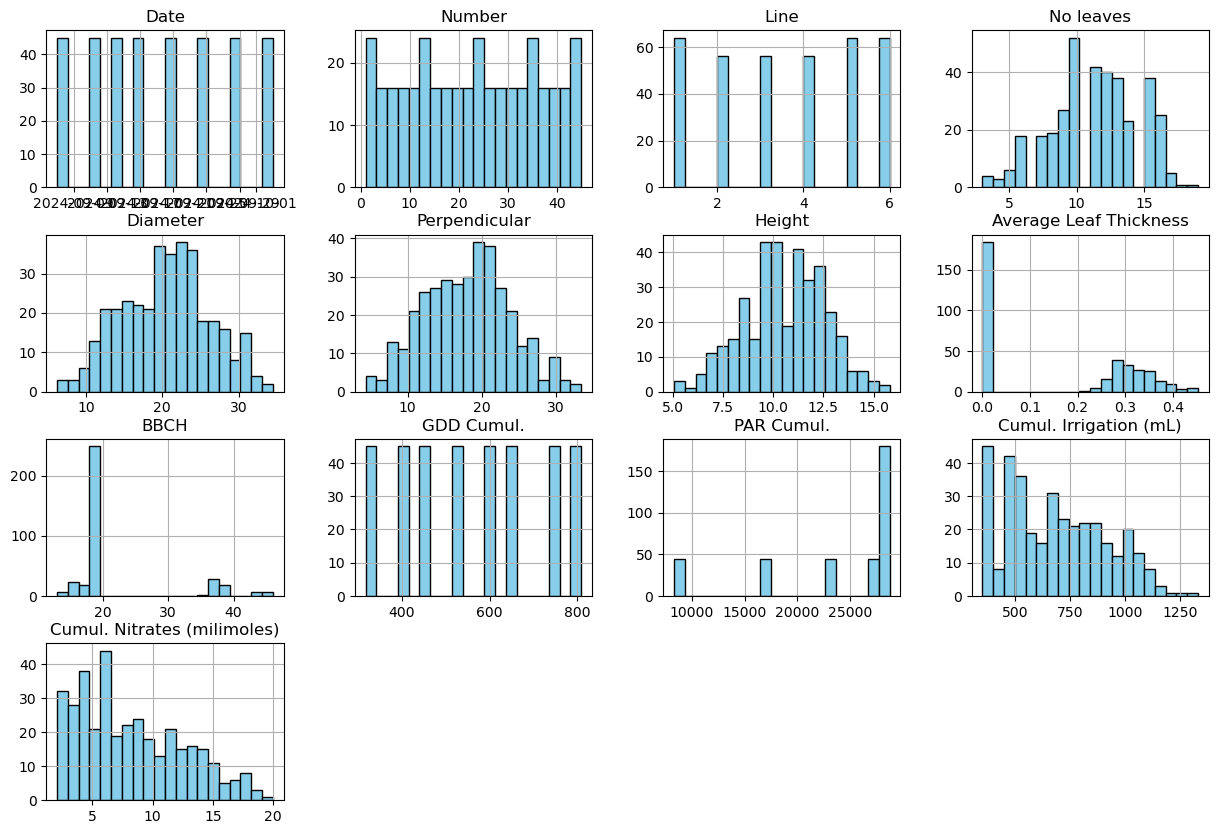

In [48]:
# Plot histograms
merged_df.hist(bins=20, figsize=(15, 10), color='skyblue', edgecolor='black')

In [49]:
merged_df.drop(columns={'Line','Number'}, inplace=True)

# Create a new column "Family Sample" by removing the last character of "Sample" for PCA
merged_df["Family Sample"] = merged_df["Sample"].str[:-2]


In [50]:
merged_df

,Date,Sample,No leaves,Diameter,Perpendicular,Height,Average Leaf Thickness,BBCH,GDD Cumul.,PAR Cumul.,Cumul. Irrigation (mL),Cumul. Nitrates (milimoles),Family Sample
0,2024-09-07,RNGRA1,12,12.9,11.1,11.80,0.0000,19,317.050000,8284.7,350.0,2.1000,RNGR
1,2024-09-07,RNGRA2,10,11.6,10.9,9.30,0.0000,19,317.050000,8284.7,350.0,2.1000,RNGR
2,2024-09-07,RNGRA3,9,9.8,9.7,10.70,0.0000,19,317.050000,8284.7,350.0,2.1000,RNGR
3,2024-09-07,RNGRA4,7,8.9,7.7,6.90,0.0000,17,317.050000,8284.7,350.0,2.1000,RNGR
4,2024-09-07,RNGRA5,7,10.2,6.8,9.50,0.0000,17,317.050000,8284.7,350.0,2.1000,RNGR
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2024-10-03,RWGRC1,16,23.6,21.7,8.55,0.3520,39,809.244245,28775.3,1084.0,18.4280,RWGR
356,2024-10-03,RWGRC2,12,28.6,27.4,13.75,0.3100,44,809.244245,28775.3,877.5,14.9175,RWGR
357,2024-10-03,RWGRC3,16,23.6,23.8,8.55,0.3350,39,809.244245,28775.3,1045.5,17.7735,RWGR
358,2024-10-03,RWGRC4,11,27.6,26.8,7.15,0.2975,45,809.244245,28775.3,1058.0,17.9860,RWGR


In [51]:
merged_df[merged_df['Sample'] == 'RNGRA1']

,Date,Sample,No leaves,Diameter,Perpendicular,Height,Average Leaf Thickness,BBCH,GDD Cumul.,PAR Cumul.,Cumul. Irrigation (mL),Cumul. Nitrates (milimoles),Family Sample
0,2024-09-07,RNGRA1,12,12.9,11.1,11.80,0.000000,19,317.050000,8284.7,350.00,2.1000,RNGR
45,2024-09-11,RNGRA1,15,14.2,13.2,12.80,0.000000,19,391.750000,16804.0,466.00,2.7960,RNGR
90,2024-09-14,RNGRA1,13,17.5,15.6,11.80,0.000000,19,457.100000,22970.1,540.25,3.2415,RNGR
135,2024-09-17,RNGRA1,16,20.3,17.3,13.20,0.000000,37,529.378430,26761.5,676.75,4.0605,RNGR
180,2024-09-20,RNGRA1,11,23.1,22.8,9.35,0.356667,37,589.001102,28775.3,732.75,4.3965,RNGR
225,2024-09-24,RNGRA1,13,29.5,26.1,10.65,0.306667,39,660.469683,28775.3,863.75,5.1825,RNGR
270,2024-09-29,RNGRA1,10,25.2,29.1,14.35,0.000000,39,743.211838,28775.3,1000.00,6.0000,RNGR
315,2024-10-03,RNGRA1,15,29.1,20.6,11.25,0.265000,44,809.244245,28775.3,1172.25,7.0335,RNGR


In [52]:
merged_df.describe()

,Date,No leaves,Diameter,Perpendicular,Height,Average Leaf Thickness,BBCH,GDD Cumul.,PAR Cumul.,Cumul. Irrigation (mL),Cumul. Nitrates (milimoles)
count,360,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000
mean,2024-09-19 08:59:59.999999744,11.258333,20.455833,18.001111,10.554583,0.156412,22.022222,562.150662,23740.187500,680.458333,8.206746
min,2024-09-07 00:00:00,3.000000,6.200000,4.300000,5.050000,0.000000,13.000000,317.050000,8284.700000,350.000000,2.100000
25%,2024-09-13 06:00:00,9.000000,16.175000,13.725000,9.337500,0.000000,19.000000,440.762500,21428.575000,477.812500,4.550000
50%,2024-09-18 12:00:00,11.000000,20.700000,18.200000,10.550000,0.000000,19.000000,559.189766,27768.400000,672.375000,7.229625
75%,2024-09-25 06:00:00,14.000000,24.100000,21.800000,12.050000,0.310000,19.000000,681.155222,28775.300000,857.000000,11.528063
max,2024-10-03 00:00:00,19.000000,34.500000,33.400000,15.800000,0.453333,46.000000,809.244245,28775.300000,1331.000000,19.953750
std,NaN,3.161826,5.698440,5.742700,1.992213,0.163414,8.086204,160.475317,7064.192611,229.556517,4.332061


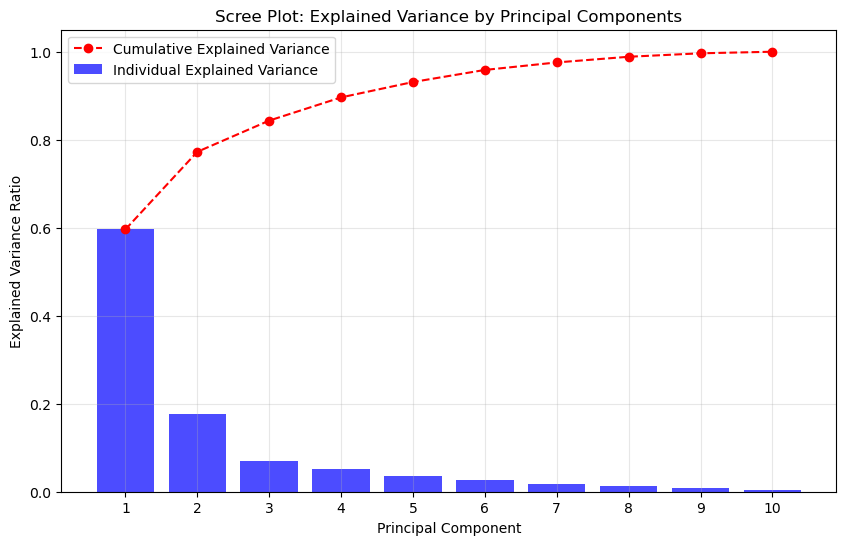

In [53]:
expl_variance = explained_variance_visualizer(merged_df)

#### <b> PCA - 2D </b>

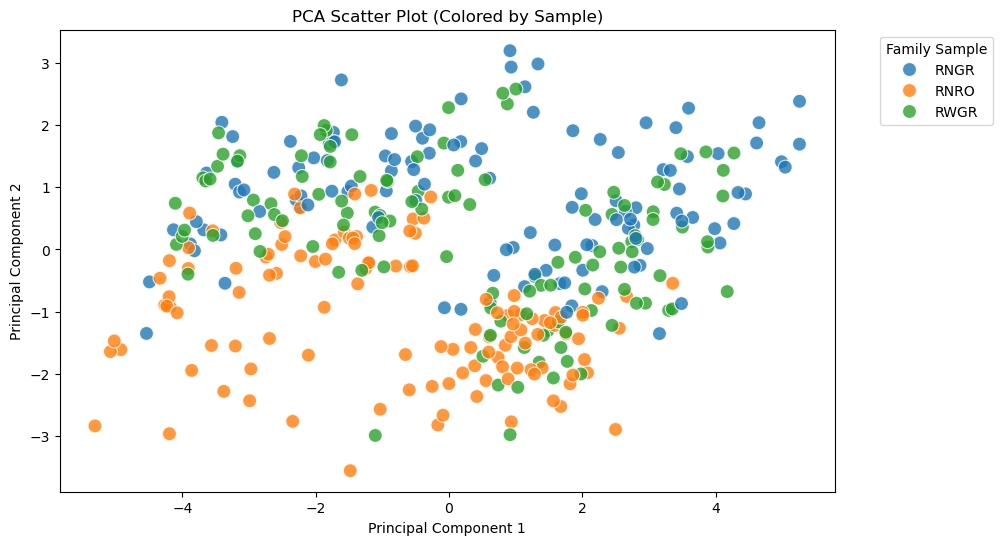

In [54]:
pc_2d, loadings = pca(merged_df, n_components=2)

#### <b> PCA 3d </b>

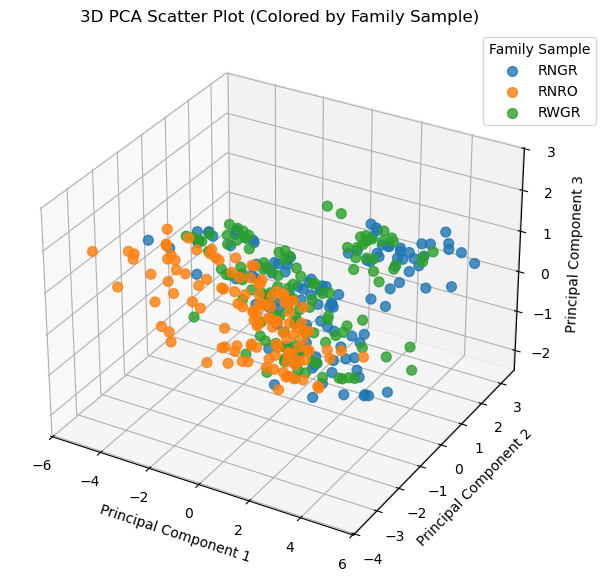

In [55]:
pc_3d, loadings_3d = pca(merged_df, n_components=3)

In [56]:
# DIFFERENT 3D PCA VISUALIZATION

# Extract numeric columns only
df_numeric = merged_df.select_dtypes(include=[np.number])

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Apply PCA with 3 components
pca = PCA(n_components=3)
pca_3d = pca.fit_transform(df_scaled)

# Create DataFrame for PCA results
df_pca = pd.DataFrame(pca_3d, columns=["PC1", "PC2", "PC3"])

# Add Family Sample column
df_pca["Family Sample"] = merged_df["Sample"].str[:-2]

# Create color mapping based on Family Sample
unique_samples = df_pca["Family Sample"].unique()

# Use Plotly's qualitative color scale
tab10_colors = plt.cm.tab10.colors
#colors = px.colors.qualitative.Set3  # Good palette with distinct colors
color_dict = dict(zip(unique_samples, tab10_colors))

# Create Plotly 3D Scatter Plot
fig = go.Figure()

# Scatter plot for each unique Family Sample
for sample in unique_samples:
    subset = df_pca[df_pca["Family Sample"] == sample]
    fig.add_trace(go.Scatter3d(
        x=subset["PC1"], y=subset["PC2"], z=subset["PC3"],
        mode='markers',
        marker=dict(
            size=5,
            color=[color_dict[sample]] * len(subset),  # Assign color from the dictionary
            opacity=0.8
        ),
        name=sample
    ))

# Update layout with axis labels and title
fig.update_layout(
    title="3D PCA Scatter Plot (Colored by Family Sample)",
    scene=dict(
        xaxis_title="Principal Component 1",
        yaxis_title="Principal Component 2",
        zaxis_title="Principal Component 3"
    ),
    legend_title="Family Sample"
)

# Show the interactive plot
fig.show()


### <b> Models </b>

In [57]:

# Get the numerical and categorical columns of the dataset

numerical_columns = merged_df.select_dtypes(exclude='object').columns
categorical_columns = merged_df.select_dtypes(include='object').columns

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [59]:
# Custom function for splitting and scaling the data
def custom_train_test_split(df, label):
    X = df.drop(columns=label)
    y = df[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test

In [70]:
def predict_all_biometry_variables(df, biometry_columns):
    results = []
    for target in biometry_columns:
        X_train, X_test, y_train, y_test = custom_train_test_split(df, label=target)
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results.append({
            'Target Variable': target,
            'MSE': mse,
            'R^2': r2
        })
    
    results_df = pd.DataFrame(results)
    return results_df

In [71]:
biometry_columns = ['No leaves', 'Diameter', 'Perpendicular', 'Height', 'Average Leaf Thickness']
results_0 = predict_all_biometry_variables(merged_df.drop(columns={'Date','Sample', 'Family Sample'}), biometry_columns)
results_0

,Target Variable,MSE,R^2
0,No leaves,4.640982,0.479415
1,Diameter,3.679306,0.891305
2,Perpendicular,3.924328,0.890411
3,Height,2.402545,0.455377
4,Average Leaf Thickness,0.006195,0.774398


In [62]:
from sklearn.linear_model import Ridge, Lasso

def predict_with_regularization(df, biometry_columns, model_type='ridge'):
    results = []
    for target in biometry_columns:
        X_train, X_test, y_train, y_test = custom_train_test_split(df, label=target)
        
        if model_type == 'ridge':
            model = Ridge(alpha=1.0)
        elif model_type == 'lasso':
            model = Lasso(alpha=0.01)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results.append({
            'Target Variable': target,
            'MSE': mse,
            'R^2': r2
        })
    
    return pd.DataFrame(results)

In [63]:
results_ridge = predict_with_regularization(merged_df.drop(columns={'Date','Sample', 'Family Sample'}), biometry_columns, 'ridge')
results_ridge

,Target Variable,MSE,R^2
0,No leaves,4.612762,0.482580
1,Diameter,3.665809,0.891704
2,Perpendicular,3.910187,0.890805
3,Height,2.406307,0.454524
4,Average Leaf Thickness,0.006103,0.777755


In [64]:
results_lasso = predict_with_regularization(merged_df.drop(columns={'Date','Sample', 'Family Sample'}), biometry_columns, 'lasso')
results_lasso

,Target Variable,MSE,R^2
0,No leaves,4.624492,0.481264
1,Diameter,3.674407,0.891450
2,Perpendicular,3.898198,0.891140
3,Height,2.425296,0.450219
4,Average Leaf Thickness,0.006084,0.778467


In [65]:
from sklearn.ensemble import RandomForestRegressor

def predict_with_random_forest(df, biometry_columns):
    results = []
    for target in biometry_columns:
        X_train, X_test, y_train, y_test = custom_train_test_split(df, label=target)
        
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results.append({
            'Target Variable': target,
            'MSE': mse,
            'R^2': r2
        })
    
    return pd.DataFrame(results)

In [66]:
results_rf = predict_with_random_forest(merged_df.drop(columns={'Date','Sample', 'Family Sample'}), biometry_columns)

In [67]:
results_rf

,Target Variable,MSE,R^2
0,No leaves,3.573924,0.599108
1,Diameter,4.186233,0.876330
2,Perpendicular,4.386583,0.877502
3,Height,2.393513,0.457424
4,Average Leaf Thickness,0.002234,0.918665


In [68]:
from xgboost import XGBRegressor

def predict_with_xgboost(df, biometry_columns):
    results = []
    for target in biometry_columns:
        X_train, X_test, y_train, y_test = custom_train_test_split(df, label=target)
        
        model = XGBRegressor(objective='reg:squarederror', random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results.append({
            'Target Variable': target,
            'MSE': mse,
            'R^2': r2
        })
    
    return pd.DataFrame(results)

In [69]:
results_xgb = predict_with_xgboost(merged_df.drop(columns={'Date','Sample', 'Family Sample'}), biometry_columns)
print("XGBoost Regression Results:")
print(results_xgb)

XGBoost Regression Results:
          Target Variable       MSE       R^2
0               No leaves  3.696006  0.585414
1                Diameter  5.026389  0.851510
2           Perpendicular  5.206327  0.854610
3                  Height  3.000374  0.319857
4  Average Leaf Thickness  0.002861  0.895826
